In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple

from definitions import ROOT_DIR
from unc.utils import load_info

plt.rcParams.update({'font.size': 18})

/Users/ruoyutao/Documents/uncertainty/venv/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [21]:
all_paths = {
    '2_linear': Path(ROOT_DIR, 'results', '2_linear'),
#     '2_nn':  Path(ROOT_DIR, 'results', '2_nn'),
    '2o_linear': Path(ROOT_DIR, 'results', '2o_linear'),
#     '2o_nn': Path(ROOT_DIR, 'results', '2o_nn')
    '2pb_linear': Path(ROOT_DIR, 'results', '2pb_linear'),
#     '2pb_nn': Path(ROOT_DIR, 'results', '2pb_nn'),
#     '2t_nn': Path(ROOT_DIR, 'results', '2t_nn')
    '2e_linear': Path(ROOT_DIR, 'results', '2e_linear'),


}

split_by = ['step_size', 'epsilon']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [22]:
def process_dir(dir_path, split_by):
    all_results = {}
        
    for f in tqdm(list(dir_path.iterdir())):
        if not f.is_file() or f.suffix != '.npy':
            continue
        info = load_info(f)
        args = info['args'].item()
        
        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

#         all_results[hparams].append((info['episode_reward'], args))
        all_results[hparams].append((args, info['episode_reward'], f))


    
    return all_results

In [23]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    
    raw_data[key] = {}
    for hparams, ret in processed.items():
        rew_lst, arg_lst, f_lst = [], [], []
        for r in ret:
            rew_lst.append(r[1])
            arg_lst.append(r[0])
            f_lst.append(r[2])
        raw_data[key][hparams] = {'rewards': np.stack(rew_lst), 'args': arg_lst, 'paths': f_lst}

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

In [26]:
# Here we get our best hparams
all_best = {}
for key, res in raw_data.items():
    stats_list = []
    for args, rew_dict in res.items():
        # we take mean over both time and seeds
        stats_list.append((args, rew_dict['rewards'].mean(), rew_dict['rewards'], rew_dict['args'], rew_dict['paths']))
    all_best[key] = sorted(stats_list, key=lambda x: x[1])[-1]
for k, v in all_best.items():
    print(k, v[0], v[1])

2_linear args(step_size=0.001, epsilon=0.1) 11.535973333333333
2o_linear args(step_size=0.001, epsilon=0.1) 16.212
2pb_linear args(step_size=0.001, epsilon=0.1) 16.207866666666668
2e_linear args(step_size=0.001, epsilon=0.1) 17.11328


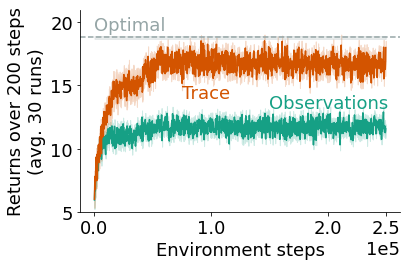

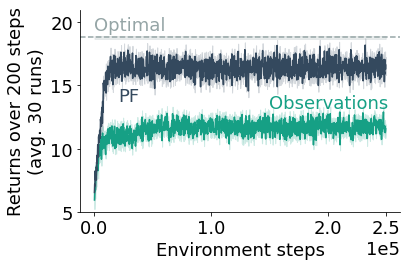

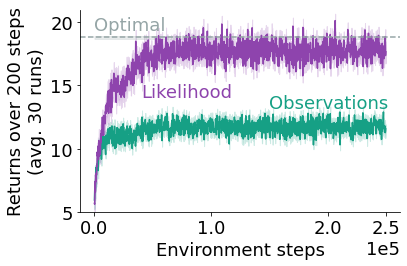

In [49]:
steps_per_eps = 200

selection = ['2_linear', '2t_nn', '2pb_linear']

plot_info = {
    '2_linear': {
        'color': '#16a085', 
        'label': {'x': 1.5e5, 'y': 13.2, 'text': 'Observations'}
    },
    
    '2o_linear': {
        'color': '#d35400',       
        'label': {'x': 0.75e5, 'y': 14.0, 'text': 'Trace'}
    },
    '2pb_linear': {
        'color': '#34495e', 
        'label': {'x': 0.2e5, 'y': 13.8, 'text': 'PF'}
    },
    '2t_nn': {
        'color': '#8e44ad', 
        'label': {'x': 1.8e5, 'y': 19.1, 'text': 'GVF'}
    },
    '2e_linear': {
        'color': '#8e44ad', 
        'label': {'x': 0.4e5, 'y': 14.1, 'text': 'Likelihood'}
    },

}
for to_plot in ['2o_linear', '2pb_linear', '2e_linear']:
    fig, ax = plt.figure(), plt.axes()

    plotting_order = ['2_linear', to_plot]
    lobster_results_path = Path(ROOT_DIR, 'results', f'{plotting_order[-1]}_lobster_results.pdf')
    # plotting_order = ['2_linear', '2pb_linear', '2e_linear', '2o_linear']


    for k in plotting_order:
        v = all_best[k]
    #     if k not in selection:
    #         continue
        data = v[2]
        key = plot_info[k]['label']['text']
        color = plot_info[k]['color']
        x = np.arange(data.shape[1]) * steps_per_eps

        means = data.mean(axis=0)
        std_err = data.std(axis=0) / np.sqrt(data.shape[0])

        ax.plot(x, means, label=key, color=color)
        plt.fill_between(x, means - std_err, means + std_err,
                             color=color, alpha=0.2)
        l_info = plot_info[k]['label']
        plt.text(l_info['x'], l_info['y'], l_info['text'], color=color, fontdict=dict(size=18))

    ax.set_ylim(5, 21)

    ax.axhline(18.8, linestyle='--', color='#95a5a6')
    plt.fill_between(x, 18.8 + 0.112, 18.8 - 0.112, color='#95a5a6', alpha=0.2)
    plt.text(0e5, 19.4, 'Optimal', color='#95a5a6', fontdict=dict(size=18))


    ax.set_xlabel('Environment steps')
    ax.set_ylabel(f"Returns over 200 steps\n(avg. 30 runs)")
    ax.set_xticks([0, 1e5, 2e5, 2.5e5])


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.tight_layout()
    # ax.set_title(f'Lobster Environment')


    plt.savefig(lobster_results_path, bbox_inches='tight')
    # plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

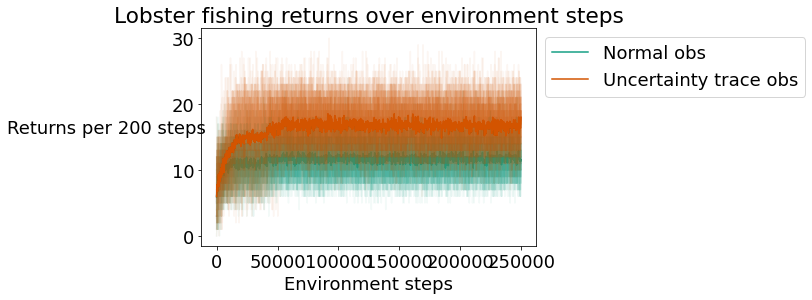

In [7]:
fig, ax = plt.figure(), plt.axes()
steps_per_eps = 200


for k, v in all_best.items():
    data = v[-1]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eps

    means = data.mean(axis=0)

    ax.plot(x, means, label=key, color=color)
    
    for y in data:
        ax.plot(x, y, color=color, alpha=0.05)



ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns per {steps_per_eps} steps", rotation=0, labelpad=65)
ax.set_title(f'Lobster fishing returns over environment steps')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

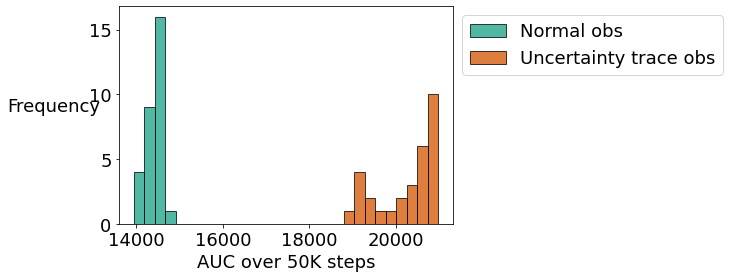

In [8]:
# we plot distribution over AUCs.
steps_per_eps = 200
fig, ax = plt.figure(), plt.axes()

all_aucs = {}
min_bin = float('inf')
max_bin = -float('inf')

for k, v in all_best.items():
    data = v[-1]
    aucs = data.sum(axis=-1)
    min_bin = min(min_bin, aucs.min())
    max_bin = max(max_bin, aucs.max())
    
bins = np.linspace(min_bin, max_bin, 30)

for k, v in all_best.items():
    data = v[-1]
    aucs = data.sum(axis=-1)
    color = plot_info[k]['color']
    key = plot_info[k]['label']
    
    ax.hist(aucs, bins=bins, color=color, label=key, alpha=0.75, edgecolor='black', linewidth=1)

ax.set_xlabel('AUC over 50K steps')
ax.set_ylabel(f"Frequency", rotation=0, labelpad=35)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [67]:
aucs.min()

3760